In [1]:
import os
#import pandas as pd
import csv
import tensorflow as tf
import matplotlib.pyplot as plt
#import seaborn as sns
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score

In [2]:
# Ścieżki do danych
base_dir = ' '
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Funkcja wczytująca obrazy z folderów
def load_images_from_directory(directory):
    images, labels = [], []
    class_names = os.listdir(directory)  # Lista podfolderów (klas)
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        for file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file)
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # Wczytanie w trybie skali szarości
            if img is not None:
                img = cv2.resize(img, (224, 224))  # Zmiana rozmiaru na 224x224
                img = img / 255.0  # Normalizacja
                images.append(img)
                labels.append(label)
    images = np.array(images).reshape(-1, 224, 224, 1)  # Dodanie wymiaru dla kanałów
    labels = np.array(labels)
    return images, labels

# Wczytanie danych
train_images, train_labels = load_images_from_directory(train_dir)
val_images, val_labels = load_images_from_directory(val_dir)
test_images, test_labels = load_images_from_directory(test_dir)

In [3]:
# Step 3: Image augmentation using ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator()  # No augmentation for validation/test

# Step 4: Prepare data generators
train_generator = train_datagen.flow(
    train_images, train_labels, batch_size=32
)

val_generator = val_test_datagen.flow(
    val_images, val_labels, batch_size=32
)

test_generator = val_test_datagen.flow(
    test_images, test_labels, batch_size=32
)

In [4]:
# Funkcja do tworzenia tf.data.Dataset
def create_dataset(images, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Tworzenie zestawów danych
train_dataset = create_dataset(train_images, train_labels)
val_dataset = create_dataset(val_images, val_labels)
test_dataset = create_dataset(test_images, test_labels)


In [5]:
def create_model():
    model = Sequential([
        Input(shape=(224, 224, 1)),  # Definiowanie kształtu wejściowego za pomocą Input
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # Sigmoid dla klasyfikacji binarnej
    ])
    
    return model
    
model = create_model()
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,168,513 (42.60 MB)

 Trainable params: 11,168,513 (42.60 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Tworzenie modelu
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Sprawdzenie poprawności danych w generatorze
for image_data, image_labels in train_dataset.take(1):
    print(f"Shape of features: {image_data.shape}")
    print(f"Shape of labels: {image_labels.shape}")

# Trenowanie modelu z wagami klas
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
)

Shape of features: (32, 224, 224, 1)
Shape of labels: (32,)
Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 39s 297ms/step - accuracy: 0.7644 - loss: 0.5554 - val_accuracy: 0.9215 - val_loss: 0.2245
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 291ms/step - accuracy: 0.8954 - loss: 0.2774 - val_accuracy: 0.9022 - val_loss: 0.2660
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 37s 284ms/step - accuracy: 0.9126 - loss: 0.2383 - val_accuracy: 0.8009 - val_loss: 0.6425
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 37s 287ms/step - accuracy: 0.8818 - loss: 0.3664 - val_accuracy: 0.8965 - val_loss: 0.2784
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 37s 283ms/step - accuracy: 0.8991 - loss: 0.2664 - val_accuracy: 0.8737 - val_loss: 0.3811
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 297ms/step - accuracy: 0.9005 - loss: 0.2572 - val_accuracy: 0.8942 - val_loss: 0.2842
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 39s 302ms/step - accuracy: 0.9142 - loss: 0.2437 - val_accuracy: 0.9283 - val_loss: 0.2408
Epoch 8/10
129/129 ━━━━

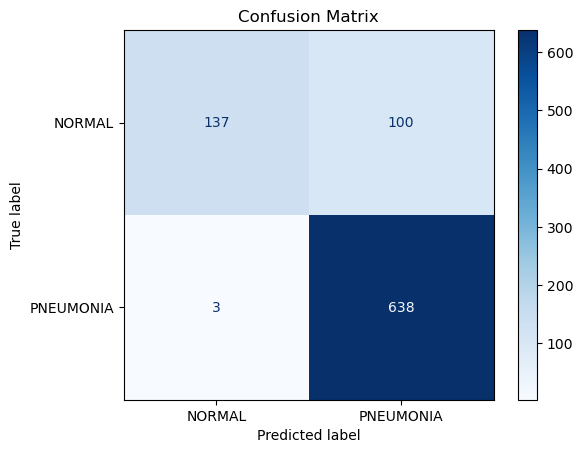

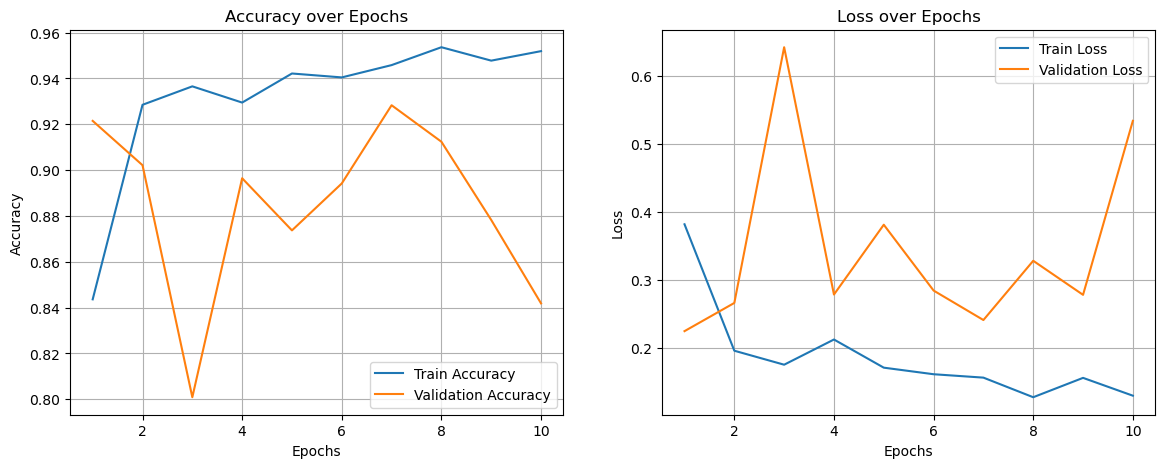

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.8854 - loss: 0.4092
Test Accuracy: 0.88
Test F1-Score: 0.9253


In [8]:
# Zbieranie prognoz modelu i rzeczywistych etykiet z test_dataset
image_labels_pred = []
image_labels_true = []

for image_data, image_labels in test_dataset:
    preds = model.predict(image_data, verbose=0)
    image_labels_pred.extend(np.round(preds).astype(int).flatten())
    image_labels_true.extend(image_labels.numpy().flatten())

# Obliczanie macierzy pomyłek
cm = confusion_matrix(image_labels_true, image_labels_pred)

# Wyświetlanie macierzy pomyłek
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NORMAL", "PNEUMONIA"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Funkcja do rysowania wykresów
def plot_training_history(history):
    # Wyciągnięcie danych z historii treningu
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(1, len(acc) + 1)
    
    # Wykres dokładności
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid()

    # Wykres funkcji straty
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid()

    plt.show()

# Wywołanie funkcji do rysowania wykresów
plot_training_history(history)

# Ewaluacja modelu
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Obliczanie F1-score
test_f1 = f1_score(image_labels_true, image_labels_pred)
print(f"Test F1-Score: {test_f1:.4f}")
